## (1) Import libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.utils import tsdisplay, decomposed_plot

In [46]:
# Record version of key libraries
from importlib.metadata import version

print('pmdarima==%s' % version('pmdarima'))

pmdarima==1.8.2


## (2) Get data

In [47]:
# Read local data
uni_data_df = pd.read_csv("../data/air_passengers.csv", index_col='ds')

uni_data_df.index = pd.to_datetime(uni_data_df.index)

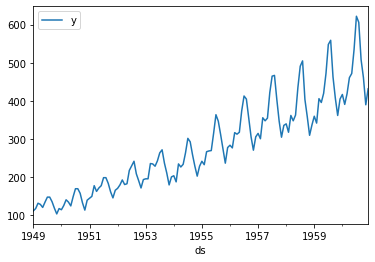

y
ds             
1949-01-01  112
1949-02-01  118
1949-03-01  132
1949-04-01  129
1949-05-01  121

In [48]:
# Visualise data
uni_data_df.plot()
plt.show()

display(uni_data_df.head())

## (3) Exploratory data analysis

Suggested number of differencing = 1
Suggested number of seasonal differencing = 1


/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pmdarima/utils/visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


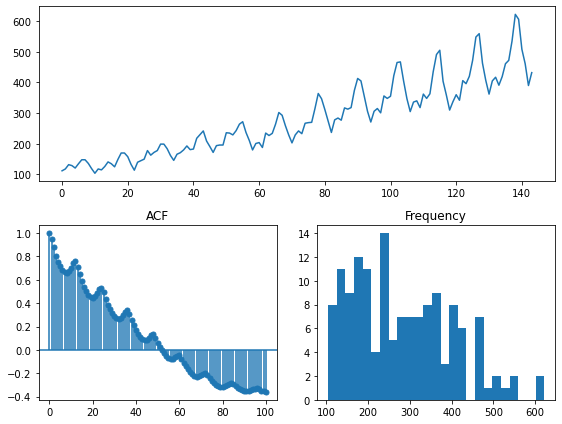

In [49]:
# Test for suggested number of differencing
n_kpss = ndiffs(uni_data_df, test='kpss')
print('Suggested number of differencing = %s' % n_kpss)

# Test for seasonal differencing term
n_ocsb = nsdiffs(uni_data_df,
        m=12,
        max_D=24,
        test='ocsb')
print('Suggested number of seasonal differencing = %s' % n_ocsb)

# Plot over time, ACF and histogram
tsdisplay(uni_data_df, lag_max=100)

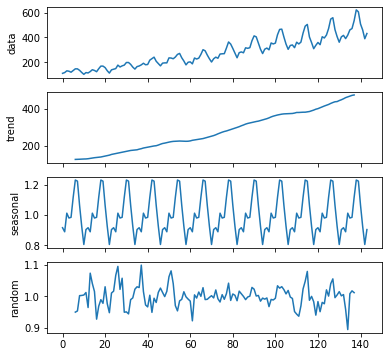

In [62]:
# Decompose the dataset into trend, seasonal and random parts.
# NOTE - this function does not support pandas
decomposed = arima.decompose(uni_data_df.iloc[:,0].to_numpy(),
                             'multiplicative', m=12)

# Plot the decomposed signal of airpassengers as a subplot
decomposed_plot(decomposed, figure_kwargs={'figsize': (6, 6)},
                show=True)

## (4) Tune ARIMA model

In [50]:
# Split data into train and test sets
train_df, test_df = model_selection.train_test_split(uni_data_df, train_size=0.75)

# Create a pipeline - feature processor + model
# NOTE - only supports univariate
pipe = pipeline.Pipeline([
    ("boxcox", ppc.BoxCoxEndogTransformer()),
    ("arima", arima.AutoARIMA(
        stepwise=True,
        seasonal=True, m=12,
        trace=1, n_jobs=-1))
])

# Fit model to data
pipe.fit(train_df)
print("Model fit:")
print(pipe)

print("Model summary:")
pipe.summary()

/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-276.684, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-353.457, Time=0.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-337.696, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-109.562, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-335.582, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-359.878, Time=1.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-296.225, Time=1.57 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-361.862, Time=2.45 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-357.876, Time=0.77 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-361.039, Time=2.20 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 186.931
Date:                            Mon, 19 Jul 2021   AIC                           -361.862
Time:                                    10:56:57   BIC                           -346.476
Sample:                                         0   HQIC                          -355.642
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0514      0.024      2.148      0.032       0.005       0.098
ar.L1          0.5636      0.105      5.393      0.000       0.359       0.768
ar.L2          0.2081      0.099      2.097      0.036       0.014       0.403
ar.S.L12      -0.5625      0.119     -4.745      0.000      -0.795      -0.330
ar.S.L24      -0.2672      0.142     -1.888      0.059      -0.545       0.010
sigma2         0.0011      0.000      6.959      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.66
Prob(Q):                              0.88   Prob(JB):                         0.02
Heteroskedasticity (H):               0.27   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## (5) Generate predictions

In [42]:
# Generate predictions with confidence intervals
preds, conf_int = pipe.predict(n_periods=10, return_conf_int=True)

/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pmdarima/arima/arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/home/cylim/anaconda3/envs/experiment_lab/lib/python3.8/site-packages/pmdarima/preprocessing/endog/boxcox.py:174: RuntimeWarning: invalid value encountered in power
  de_exp = numer ** (1. / lam1)  # de-exponentiate


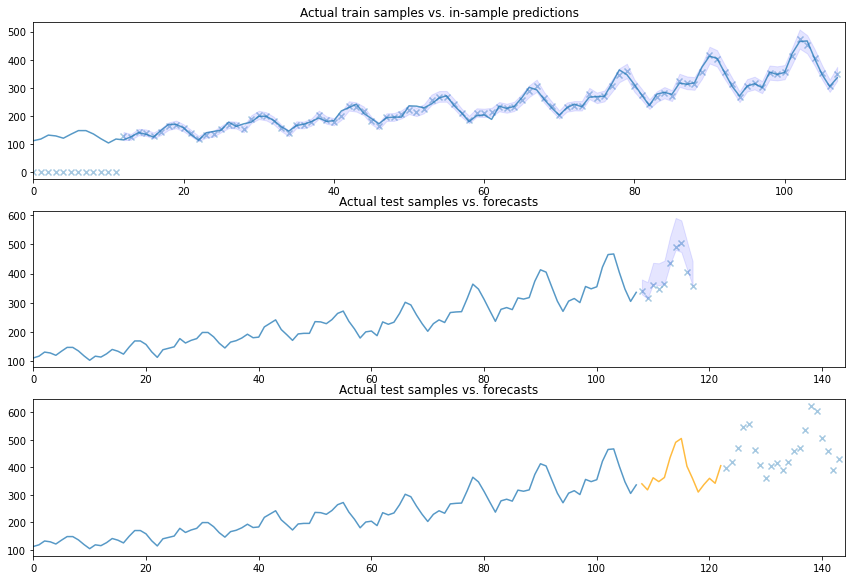

In [43]:
# Plot predictions
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

# Visualize goodness of fit
in_sample_preds, in_sample_confint = \
    pipe.predict_in_sample(X=None, return_conf_int=True)

n_train = train_df.shape[0]

x0 = np.arange(n_train)
axes[0].plot(x0, train_df, alpha=0.75)
axes[0].scatter(x0, in_sample_preds, alpha=0.4, marker='x')
axes[0].fill_between(x0, in_sample_confint[:, 0], in_sample_confint[:, 1],
                     alpha=0.1, color='b')
axes[0].set_title('Actual train samples vs. in-sample predictions')
axes[0].set_xlim((0, x0.shape[0]))

# Visualize actual + predicted
x1 = np.arange(n_train + preds.shape[0])
axes[1].plot(x1[:n_train], train_df, alpha=0.75)
axes[1].scatter(x1[n_train:], test_df[:preds.shape[0]], alpha=0.4, marker='x')
axes[1].fill_between(x1[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
axes[1].set_title('Actual test samples vs. forecasts')
axes[1].set_xlim((0, uni_data_df.shape[0]))

# We can also call `update` directly on the pipeline object, which will update
# the intermittent transformers, where necessary:
newly_observed, still_test = test_df[:15], test_df[15:]
pipe.update(newly_observed, maxiter=10)

# Calling predict will now predict from newly observed values
new_preds = pipe.predict(still_test.shape[0])

x2 = np.arange(uni_data_df.shape[0])
n_trained_on = n_train + newly_observed.shape[0]

axes[2].plot(x2[:n_train], train_df, alpha=0.75)
axes[2].plot(x2[n_train: n_trained_on], newly_observed, alpha=0.75, c='orange')
axes[2].scatter(x2[n_trained_on:], still_test, alpha=0.4, marker='x')
axes[2].set_title('Actual test samples vs. forecasts')
axes[2].set_xlim((0, uni_data_df.shape[0]))

plt.show()